# 11_nndl_cv_mlp1

We will experiment with Neural Networks and Deep Learning on the no_na dataset. This is mlp1, our first version of multi-layer perceptron 

In [1]:
''' data and math '''
import pandas as pd
import numpy as np

''' plotting images '''
from matplotlib import pyplot as plt
%matplotlib inline

''' traversing directories '''
import os
from pathlib import Path

''' utilities '''
from tqdm import tqdm

''' metrics '''
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

''' preprocessing '''
from sklearn.preprocessing import StandardScaler

In [2]:
''' used to reference the root directory, for directory traversal ''' 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = Path('/content/gdrive/My Drive/it3011_project')

Mounted at /content/gdrive


# Loading data

In [3]:
# load data
train = pd.read_csv(root_dir/"data/train_no_na.csv")
test = pd.read_csv(root_dir/"data/test_no_na.csv")
print("data loaded")

data loaded


In [4]:
# check shape
print(train.shape)
print(test.shape)

(279331, 138)
(120163, 138)


In [5]:
# create train/test sets
features = [feature for feature in test.keys() if "feature" in feature]
x_train = train.loc[:, features].values
y_train = train.loc[:,['action']].values.flatten()
x_test = test.loc[:, features].values
y_test = test.loc[:,['action']].values.flatten()
print("train/test set created")

train/test set created


# Helper functions

In [6]:
# constants
SEED = 42

# cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=SEED, shuffle=True)

In [7]:
# create the utility score, which takes in the prediction value and the ground truth action and generates a score
# link: https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation

# data: original train/test data    action: the y-value. can either be y_pred or original values too, if we want the max score attainable
def utility_score(data, action): 
  dates_set = set(data.date.values)
  dates = data.loc[:, ['date']].values.flatten()
  weights = data.loc[:, ['weight']].values.flatten()
  resps = data.loc[:, ['resp']].values.flatten()
  actions = action.flatten()

  i = len(dates_set)
  p_i = []

  for date in dates_set:
    indices = np.where(dates == date)[0]
    p_i_temp = 0
    for j in indices:
      p_i_temp = p_i_temp + weights[j] * resps[j] * actions[j]
    p_i.append(p_i_temp)
  
  p_i_squared = [p_i1*p_i2 for p_i1,p_i2 in zip(p_i,p_i)]
  t = ( sum(p_i) / np.sqrt(sum(p_i_squared)) ) * np.sqrt(250/i)
  u = min(max(t, 0), 6) * sum(p_i)

  return u

def max_train_utility_score(data=train, action=y_train):
  return utility_score(data, action)

def max_test_utility_score(data=test, action=y_test):
  return utility_score(data, action)

In [8]:
def model_scores(model, test, x_test, y_test):
  y_pred = model.predict(x_test) 
  y_pred = (y_pred > 0.5).astype(int)
  
  # # get some scores from helpers
  utility = utility_score(test, y_pred)
  accuracy =  accuracy_score(y_test, y_pred)

  # # confusion matrix
  # print("confusion matrix")
  cm = confusion_matrix(y_test, y_pred)
  true_pos = cm[1][1]
  true_neg = cm[0][0]
  false_pos = cm[0][1]
  false_neg = cm[1][0]

  # # plot confusion matrix
  # fig, ax = plt.subplots(figsize=(3, 3))
  # ax.imshow(cm)
  # ax.grid(False)
  # ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
  # ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
  # ax.set_ylim(1.5, -0.5)
  # for i in range(2):
  #     for j in range(2):
  #         ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
  # plt.show()  

  # # AUC-ROC
  # print("AUC_ROC")
  logit_roc_auc = roc_auc_score(y_test, y_pred)

  # # plot auc-roc
  # fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
  # plt.figure()
  # plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  # plt.plot([0, 1], [0, 1],'r--')
  # plt.xlim([0.0, 1.0])
  # plt.ylim([0.0, 1.05])
  # plt.xlabel('False Positive Rate')
  # plt.ylabel('True Positive Rate')
  # plt.title('Receiver operating characteristic')
  # plt.legend(loc="lower right")
  # plt.show()

  return utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg

In [9]:
import datetime
import csv

def save_scores(output_filename, workbook_name, model_name, model_params, utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg):
  # create output file if not exists
  try:
    f = open(root_dir/output_filename)
  except IOError:
    with open (root_dir/output_filename, 'a') as csvfile:
      headers = ["workbook_name", "model_name", "model_params", "utility", "accuracy", "logit_roc_auc", "true_pos", "true_neg", "false_pos", "false_neg", "timestamp"]
      writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n',fieldnames=headers)
      writer.writeheader() 
      print("created output file")  
    csvfile.close()

  # output file exists, append
  timestamp = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
  
  ''' create another df that looks just like the excel file and concat with ''' 
  new_scores = pd.DataFrame(np.array([[workbook_name, model_name, model_params, utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg, timestamp]]),
                   columns=["workbook_name", "model_name", "model_params", "utility", "accuracy", "logit_roc_auc", "true_pos", "true_neg", "false_pos", "false_neg", "timestamp"],
                  )

  new_scores.to_csv(root_dir/output_filename, mode='a', header=False, index=False)
  print("saved model metrics")

In [10]:
'''
used to generate the PosixPath variables for the results to save
'''
def results_paths(root_dir=root_dir):
    PATH_RESULTS = root_dir /'results_nndl'
    PATH_HISTORIES = PATH_RESULTS / 'histories'
    PATH_FIGURES = PATH_RESULTS / 'figures'
    PATH_CHECKPOINTS = PATH_RESULTS / 'checkpoints'
    PATH_PREDICTIONS = PATH_RESULTS / 'predictions'

    return PATH_RESULTS, PATH_HISTORIES, PATH_FIGURES, PATH_CHECKPOINTS, PATH_PREDICTIONS


''' 
used to save the history of a model as a npy file
'''
# filename like 'history/model_name.npy'
def history_saver(history, model_name, history_save_path, already_npy=False):
  history_json = {}

  if already_npy:
    history_npy = history
  else:
    history_npy = history.history

  np.save(history_save_path/model_name, history_npy)
  print("History saved")



''' 
used to load the history of a model from a npy file
'''
# filename like 'history/model_name.npy'
def history_loader(model_name, history_save_path):
  history_save_path = history_save_path/str(model_name+'.npy')
  history=np.load(history_save_path,allow_pickle='TRUE').item()
  print('History loaded')
  
  return history 

'''
used to plot the metrics for a given history
'''
def plot_metrics(history, model_name, figure_save_path):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # print(history.keys())

    # plot losses
    train_loss = history['loss']
    val_loss = history['val_loss']
    loss_title = 'loss against epochs'

    ax1.plot(train_loss, label='train')
    ax1.plot(val_loss, label='val')
    ax1.set_title(loss_title)
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epochs')
    ax1.legend()

    # plot accuracy_score
    accuracy_score = history['accuracy']
    val_accuracy_score = history['val_accuracy']
    accuracy_score_title = 'accuracy_score against epochs'

    ax2.plot(accuracy_score, label='train')
    ax2.plot(val_accuracy_score, label='val')
    ax2.set_title(accuracy_score_title)
    ax2.set_ylabel('accuracy_score')
    ax2.set_xlabel('epochs')
    ax2.legend()


    # plot accuracy_score
    auc_score = history['auc']
    val_auc_score = history['val_auc']
    auc_score_title = 'auc_score against epochs'

    ax3.plot(auc_score, label='train')
    ax3.plot(val_auc_score, label='val')
    ax3.set_title(auc_score_title)
    ax3.set_ylabel('auc_score')
    ax3.set_xlabel('epochs')
    ax3.legend()


    # save figure
    fig.suptitle('Metrics for model: ' + model_name)
    plt.savefig(figure_save_path/f'{model_name}.png')

    plt.show()  

# Neural Network - Model 1 (Epochs)

In [11]:
!pip install keras_tqdm

In [12]:
import tensorflow as tf
import tensorflow.keras as keras

from keras_tqdm import TQDMCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import BinaryAccuracy, AUC

tf.random.set_seed(SEED)
np.random.seed(SEED)

In [13]:
PATH_RESULTS, PATH_HISTORIES, PATH_FIGURES, PATH_CHECKPOINTS, PATH_PREDICTIONS = results_paths()

In [14]:
def create_mlp(num_columns, hidden_units, activation, dropout_rates, learning_rate): 
  inp = Input(shape=(num_columns,))
  x = BatchNormalization()(inp)
  x = Dropout(dropout_rates[0])(x)

  for i in range(len(hidden_units)):   
    x = Dense(hidden_units[i])(x)
    x = Activation(activation)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rates[i+1])(x)

  x = Dense(1)(x)
  out = Activation("sigmoid")(x)

  model = Model(inputs=inp, outputs=out)

  model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=BinaryCrossentropy(label_smoothing=1e-4),
    metrics=[BinaryAccuracy(name="accuracy"), AUC(name="auc")]
  )

  return model

In [15]:
# settings to vary

# epochs default = 100
epochs = [50, 100, 400] 

# batch_sizes default = [1024]
batch_sizes = [1024]

# hidden_units default = [100, 200, 400, 200]
hidden_units = [
    [100, 200, 400, 200]
]

# dropout_rates should have 1 more value than hidden_units
# dropout_rates default = [0.2, 0.2, 0.2, 0.2, 0.2]
dropout_rates = [
    [0.2, 0.2, 0.2, 0.2, 0.2]
] 

# activations default = [tf.keras.activations.relu]
activations = [tf.keras.activations.relu]

# learning_rates default = [1e-4]
learning_rates = [1e-4]


model_name:  mlp1_epochs_50
model_params:  batch_size=1024, hidden_unit=[100, 200, 400, 200], activation=<function relu at 0x7f9e9fea93b0>, dropout_rate=[0.2, 0.2, 0.2, 0.2, 0.2], learning_rate=0.0001, epoch=50
training model fold 1
Epoch 1/50
246/246 [==============================] - 7s 9ms/step - loss: 0.8280 - accuracy: 0.5008 - auc: 0.5024 - val_loss: 0.6966 - val_accuracy: 0.5166 - val_auc: 0.5237
Epoch 2/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7584 - accuracy: 0.5077 - auc: 0.5101 - val_loss: 0.6942 - val_accuracy: 0.5246 - val_auc: 0.5341
Epoch 3/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7411 - accuracy: 0.5067 - auc: 0.5090 - val_loss: 0.6919 - val_accuracy: 0.5290 - val_auc: 0.5396
Epoch 4/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7285 - accuracy: 0.5097 - auc: 0.5133 - val_loss: 0.6899 - val_accuracy: 0.5322 - val_auc: 0.5458
Epoch 5/50
246/246 [==============================] - 2s 7ms/step - lo

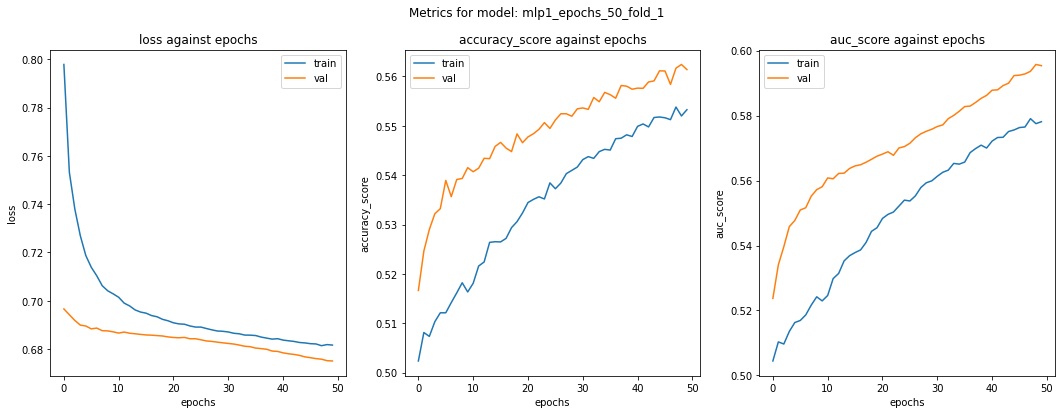

training model fold 2
Epoch 1/50
246/246 [==============================] - 3s 8ms/step - loss: 0.8534 - accuracy: 0.5028 - auc: 0.5029 - val_loss: 0.6953 - val_accuracy: 0.5215 - val_auc: 0.5340
Epoch 2/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7663 - accuracy: 0.5068 - auc: 0.5100 - val_loss: 0.6940 - val_accuracy: 0.5275 - val_auc: 0.5428
Epoch 3/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7454 - accuracy: 0.5112 - auc: 0.5133 - val_loss: 0.6908 - val_accuracy: 0.5353 - val_auc: 0.5500
Epoch 4/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7322 - accuracy: 0.5095 - auc: 0.5133 - val_loss: 0.6886 - val_accuracy: 0.5397 - val_auc: 0.5548
Epoch 5/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7251 - accuracy: 0.5096 - auc: 0.5135 - val_loss: 0.6882 - val_accuracy: 0.5397 - val_auc: 0.5560
Epoch 6/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7164 - accuracy: 0.5120 - auc: 0

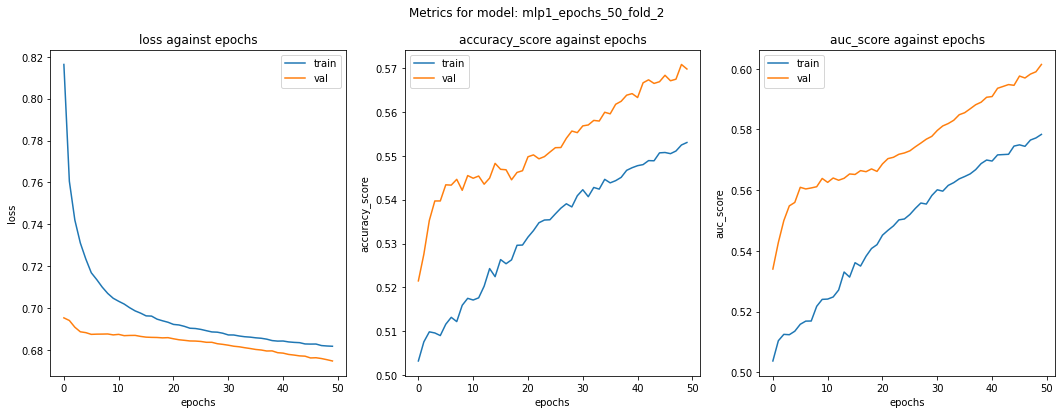

training model fold 3
Epoch 1/50
246/246 [==============================] - 4s 9ms/step - loss: 0.8248 - accuracy: 0.5038 - auc: 0.5055 - val_loss: 0.6968 - val_accuracy: 0.5139 - val_auc: 0.5216
Epoch 2/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7596 - accuracy: 0.5065 - auc: 0.5081 - val_loss: 0.6956 - val_accuracy: 0.5201 - val_auc: 0.5299
Epoch 3/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7400 - accuracy: 0.5087 - auc: 0.5110 - val_loss: 0.6930 - val_accuracy: 0.5267 - val_auc: 0.5377
Epoch 4/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7292 - accuracy: 0.5079 - auc: 0.5112 - val_loss: 0.6913 - val_accuracy: 0.5294 - val_auc: 0.5418
Epoch 5/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7211 - accuracy: 0.5113 - auc: 0.5148 - val_loss: 0.6903 - val_accuracy: 0.5312 - val_auc: 0.5453
Epoch 6/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7153 - accuracy: 0.5127 - auc: 0

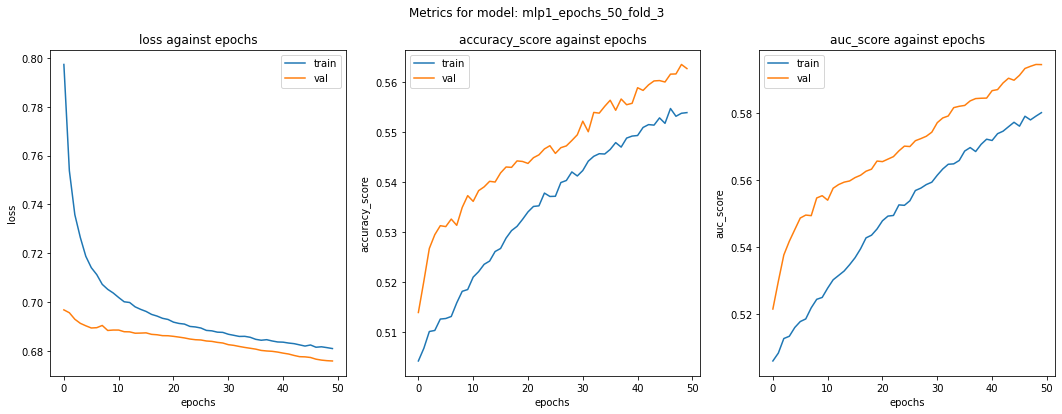

training model fold 4
Epoch 1/50
246/246 [==============================] - 3s 9ms/step - loss: 0.8282 - accuracy: 0.5049 - auc: 0.5053 - val_loss: 0.6980 - val_accuracy: 0.5190 - val_auc: 0.5253
Epoch 2/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7595 - accuracy: 0.5063 - auc: 0.5083 - val_loss: 0.6948 - val_accuracy: 0.5239 - val_auc: 0.5342
Epoch 3/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7395 - accuracy: 0.5101 - auc: 0.5134 - val_loss: 0.6928 - val_accuracy: 0.5286 - val_auc: 0.5369
Epoch 4/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7286 - accuracy: 0.5095 - auc: 0.5137 - val_loss: 0.6906 - val_accuracy: 0.5286 - val_auc: 0.5388
Epoch 5/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7221 - accuracy: 0.5083 - auc: 0.5109 - val_loss: 0.6893 - val_accuracy: 0.5289 - val_auc: 0.5437
Epoch 6/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7145 - accuracy: 0.5134 - auc: 0

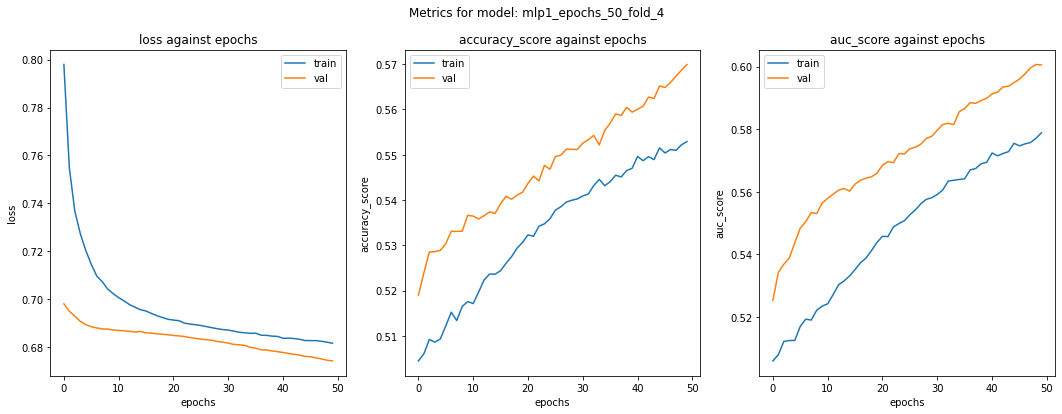

training model fold 5
Epoch 1/50
246/246 [==============================] - 4s 8ms/step - loss: 0.8405 - accuracy: 0.5013 - auc: 0.5026 - val_loss: 0.6996 - val_accuracy: 0.5201 - val_auc: 0.5293
Epoch 2/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7614 - accuracy: 0.5083 - auc: 0.5101 - val_loss: 0.6952 - val_accuracy: 0.5230 - val_auc: 0.5322
Epoch 3/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7399 - accuracy: 0.5100 - auc: 0.5135 - val_loss: 0.6935 - val_accuracy: 0.5268 - val_auc: 0.5365
Epoch 4/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7300 - accuracy: 0.5101 - auc: 0.5133 - val_loss: 0.6913 - val_accuracy: 0.5264 - val_auc: 0.5405
Epoch 5/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7225 - accuracy: 0.5109 - auc: 0.5146 - val_loss: 0.6904 - val_accuracy: 0.5297 - val_auc: 0.5422
Epoch 6/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7158 - accuracy: 0.5115 - auc: 0

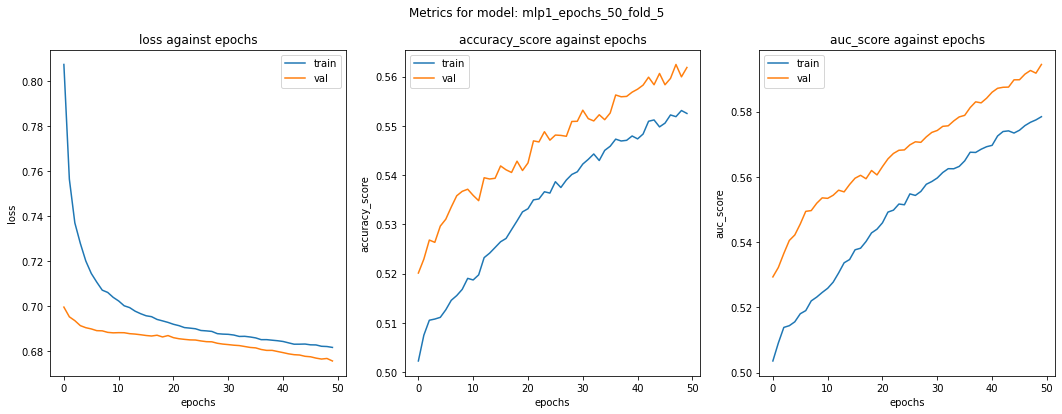

training model fold 6
Epoch 1/50
246/246 [==============================] - 3s 8ms/step - loss: 0.8235 - accuracy: 0.5031 - auc: 0.5052 - val_loss: 0.6958 - val_accuracy: 0.5194 - val_auc: 0.5275
Epoch 2/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7538 - accuracy: 0.5077 - auc: 0.5112 - val_loss: 0.6944 - val_accuracy: 0.5246 - val_auc: 0.5342
Epoch 3/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7363 - accuracy: 0.5092 - auc: 0.5122 - val_loss: 0.6925 - val_accuracy: 0.5216 - val_auc: 0.5350
Epoch 4/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7255 - accuracy: 0.5099 - auc: 0.5135 - val_loss: 0.6905 - val_accuracy: 0.5300 - val_auc: 0.5418
Epoch 5/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7180 - accuracy: 0.5122 - auc: 0.5171 - val_loss: 0.6898 - val_accuracy: 0.5327 - val_auc: 0.5434
Epoch 6/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7134 - accuracy: 0.5098 - auc: 0

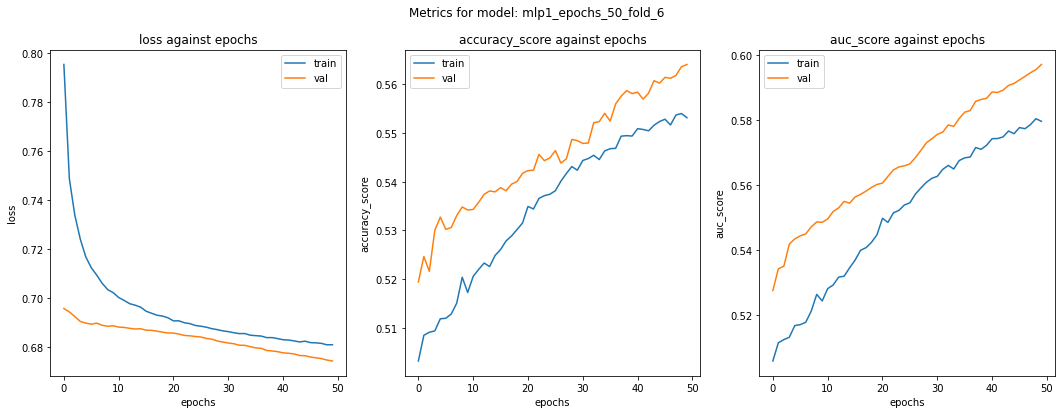

training model fold 7
Epoch 1/50
246/246 [==============================] - 4s 8ms/step - loss: 0.8498 - accuracy: 0.5023 - auc: 0.5038 - val_loss: 0.7046 - val_accuracy: 0.5006 - val_auc: 0.5120
Epoch 2/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7667 - accuracy: 0.5077 - auc: 0.5103 - val_loss: 0.6987 - val_accuracy: 0.5149 - val_auc: 0.5262
Epoch 3/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7457 - accuracy: 0.5079 - auc: 0.5113 - val_loss: 0.6947 - val_accuracy: 0.5175 - val_auc: 0.5276
Epoch 4/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7329 - accuracy: 0.5074 - auc: 0.5120 - val_loss: 0.6929 - val_accuracy: 0.5175 - val_auc: 0.5334
Epoch 5/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7262 - accuracy: 0.5079 - auc: 0.5107 - val_loss: 0.6912 - val_accuracy: 0.5230 - val_auc: 0.5382
Epoch 6/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7175 - accuracy: 0.5110 - auc: 0

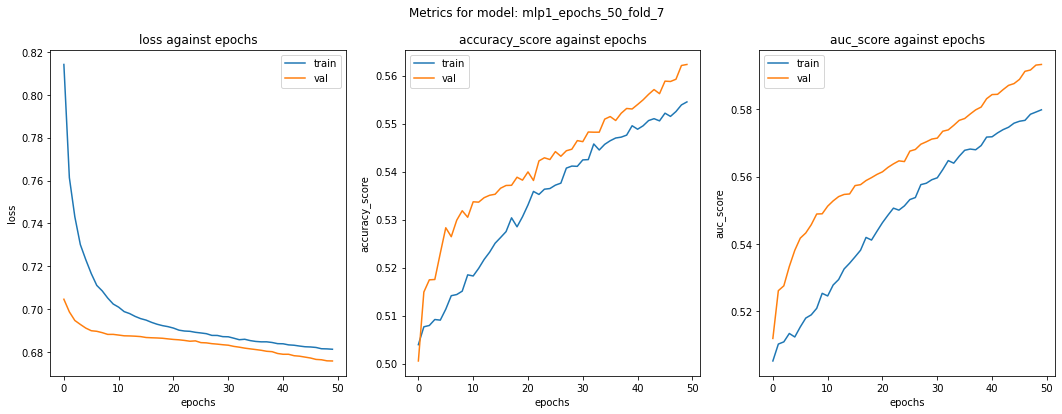

training model fold 8
Epoch 1/50
246/246 [==============================] - 4s 9ms/step - loss: 0.8284 - accuracy: 0.5026 - auc: 0.5041 - val_loss: 0.6967 - val_accuracy: 0.5182 - val_auc: 0.5249
Epoch 2/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7602 - accuracy: 0.5035 - auc: 0.5050 - val_loss: 0.6942 - val_accuracy: 0.5246 - val_auc: 0.5342
Epoch 3/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7382 - accuracy: 0.5080 - auc: 0.5105 - val_loss: 0.6918 - val_accuracy: 0.5238 - val_auc: 0.5372
Epoch 4/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7268 - accuracy: 0.5090 - auc: 0.5118 - val_loss: 0.6897 - val_accuracy: 0.5285 - val_auc: 0.5443
Epoch 5/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7185 - accuracy: 0.5146 - auc: 0.5194 - val_loss: 0.6888 - val_accuracy: 0.5337 - val_auc: 0.5474
Epoch 6/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7154 - accuracy: 0.5109 - auc: 0

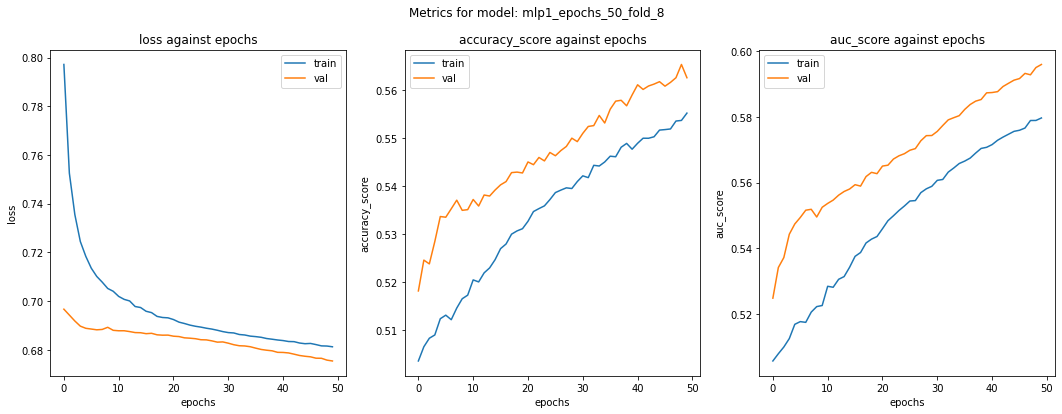

training model fold 9
Epoch 1/50
246/246 [==============================] - 4s 9ms/step - loss: 0.8299 - accuracy: 0.5039 - auc: 0.5052 - val_loss: 0.7034 - val_accuracy: 0.5026 - val_auc: 0.5156
Epoch 2/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7597 - accuracy: 0.5091 - auc: 0.5118 - val_loss: 0.6980 - val_accuracy: 0.5149 - val_auc: 0.5252
Epoch 3/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7392 - accuracy: 0.5097 - auc: 0.5130 - val_loss: 0.6944 - val_accuracy: 0.5210 - val_auc: 0.5323
Epoch 4/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7286 - accuracy: 0.5100 - auc: 0.5126 - val_loss: 0.6926 - val_accuracy: 0.5298 - val_auc: 0.5396
Epoch 5/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7199 - accuracy: 0.5125 - auc: 0.5175 - val_loss: 0.6904 - val_accuracy: 0.5316 - val_auc: 0.5447
Epoch 6/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7147 - accuracy: 0.5118 - auc: 0

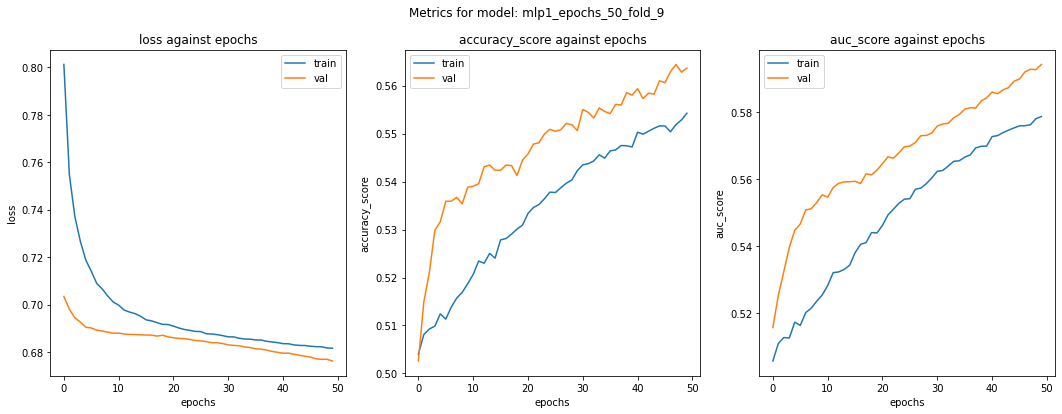

training model fold 10
Epoch 1/50
246/246 [==============================] - 4s 9ms/step - loss: 0.8175 - accuracy: 0.5041 - auc: 0.5062 - val_loss: 0.6944 - val_accuracy: 0.5225 - val_auc: 0.5321
Epoch 2/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7558 - accuracy: 0.5073 - auc: 0.5094 - val_loss: 0.6944 - val_accuracy: 0.5257 - val_auc: 0.5358
Epoch 3/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7367 - accuracy: 0.5108 - auc: 0.5129 - val_loss: 0.6915 - val_accuracy: 0.5327 - val_auc: 0.5430
Epoch 4/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7263 - accuracy: 0.5089 - auc: 0.5119 - val_loss: 0.6897 - val_accuracy: 0.5343 - val_auc: 0.5489
Epoch 5/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7176 - accuracy: 0.5117 - auc: 0.5176 - val_loss: 0.6891 - val_accuracy: 0.5364 - val_auc: 0.5511
Epoch 6/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7122 - accuracy: 0.5115 - auc: 

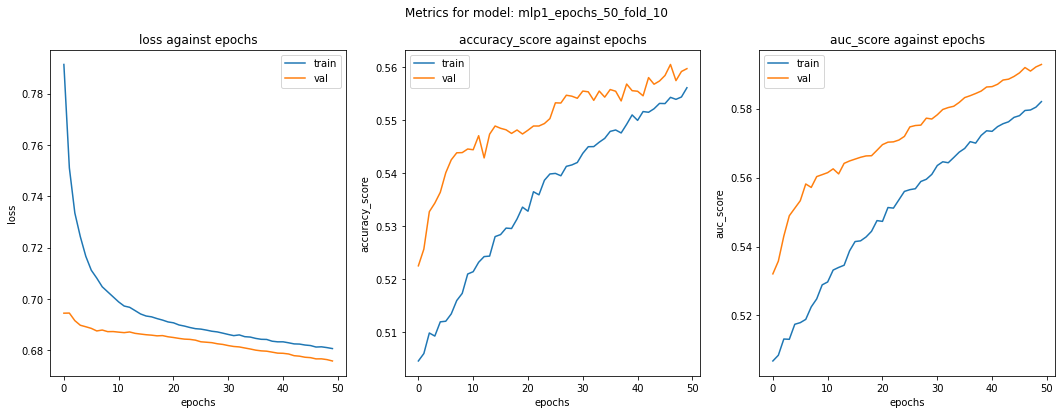

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [638.6747239586505, 0.5637970808910031, 0.5632404083284648, 8408.1, 7340.5, 6339.7, 5844.8]
saved model metrics

model_name:  mlp1_epochs_100
model_params:  batch_size=1024, hidden_unit=[100, 200, 400, 200], activation=<function relu at 0x7f9e9fea93b0>, dropout_rate=[0.2, 0.2, 0.2, 0.2, 0.2], learning_rate=0.0001, epoch=100
training model fold 1
Epoch 1/100
246/246 [==============================] - 4s 9ms/step - loss: 0.8525 - accuracy: 0.5022 - auc: 0.5021 - val_loss: 0.7041 - val_accuracy: 0.5093 - val_auc: 0.5314
Epoch 2/100
246/246 [==============================] - 2s 7ms/step - loss: 0.7707 - accuracy: 0.5068 - auc: 0.5093 - val_loss: 0.6963 - val_accuracy: 0.5247 - val_auc: 0.5377
Epoch 3/100
246/246 [==============================] - 2s 7ms/step - loss: 0.7478 - accuracy: 0.5074 - auc: 0.5110 - val_loss: 0.6921 - val_accuracy: 0.5257 - val_auc: 0.5411
Epoch 4/100
246/246 [

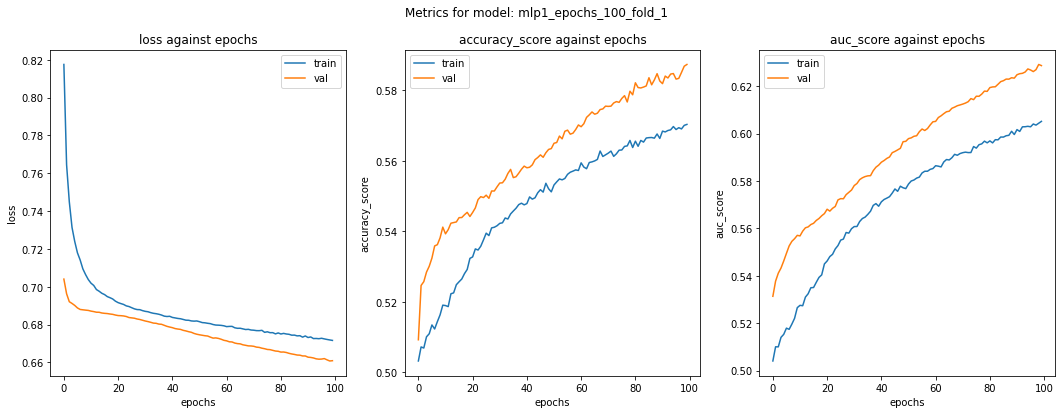

training model fold 2
Epoch 1/100
246/246 [==============================] - 4s 9ms/step - loss: 0.8422 - accuracy: 0.5040 - auc: 0.5047 - val_loss: 0.7065 - val_accuracy: 0.5150 - val_auc: 0.5307
Epoch 2/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7665 - accuracy: 0.5074 - auc: 0.5104 - val_loss: 0.6975 - val_accuracy: 0.5312 - val_auc: 0.5388
Epoch 3/100
246/246 [==============================] - 2s 7ms/step - loss: 0.7475 - accuracy: 0.5059 - auc: 0.5069 - val_loss: 0.6932 - val_accuracy: 0.5329 - val_auc: 0.5452
Epoch 4/100
246/246 [==============================] - 2s 7ms/step - loss: 0.7321 - accuracy: 0.5092 - auc: 0.5124 - val_loss: 0.6907 - val_accuracy: 0.5332 - val_auc: 0.5508
Epoch 5/100
246/246 [==============================] - 2s 7ms/step - loss: 0.7233 - accuracy: 0.5096 - auc: 0.5129 - val_loss: 0.6895 - val_accuracy: 0.5372 - val_auc: 0.5524
Epoch 6/100
246/246 [==============================] - 2s 7ms/step - loss: 0.7164 - accuracy: 0.5117 - 

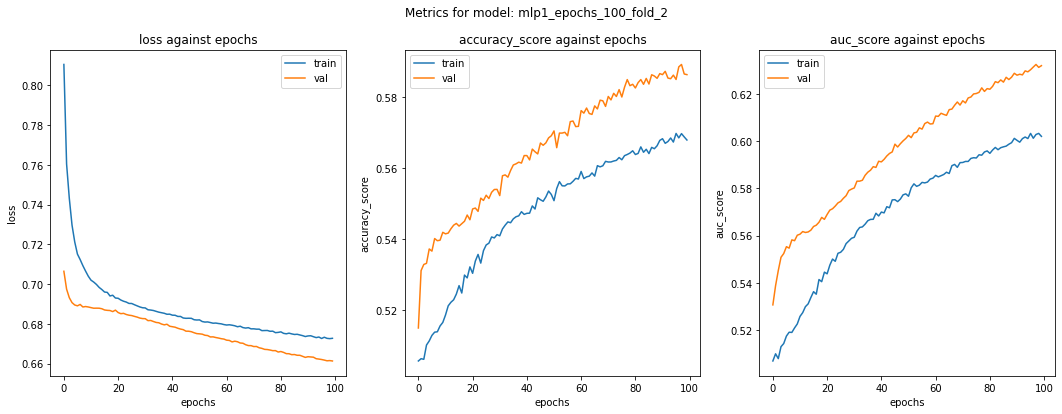

training model fold 3
Epoch 1/100
246/246 [==============================] - 4s 9ms/step - loss: 0.8344 - accuracy: 0.5007 - auc: 0.5028 - val_loss: 0.7027 - val_accuracy: 0.5105 - val_auc: 0.5257
Epoch 2/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7585 - accuracy: 0.5103 - auc: 0.5122 - val_loss: 0.6968 - val_accuracy: 0.5193 - val_auc: 0.5331
Epoch 3/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7404 - accuracy: 0.5085 - auc: 0.5109 - val_loss: 0.6939 - val_accuracy: 0.5220 - val_auc: 0.5375
Epoch 4/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7297 - accuracy: 0.5100 - auc: 0.5134 - val_loss: 0.6914 - val_accuracy: 0.5280 - val_auc: 0.5423
Epoch 5/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7222 - accuracy: 0.5090 - auc: 0.5136 - val_loss: 0.6906 - val_accuracy: 0.5294 - val_auc: 0.5437
Epoch 6/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7157 - accuracy: 0.5139 - 

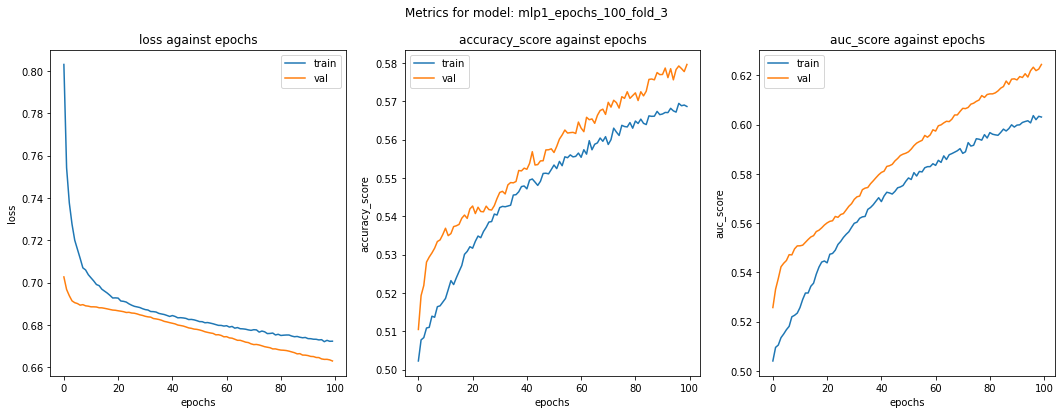

training model fold 4
Epoch 1/100
246/246 [==============================] - 4s 10ms/step - loss: 0.8385 - accuracy: 0.5003 - auc: 0.5017 - val_loss: 0.6980 - val_accuracy: 0.5143 - val_auc: 0.5268
Epoch 2/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7611 - accuracy: 0.5068 - auc: 0.5077 - val_loss: 0.6937 - val_accuracy: 0.5246 - val_auc: 0.5396
Epoch 3/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7389 - accuracy: 0.5113 - auc: 0.5145 - val_loss: 0.6908 - val_accuracy: 0.5301 - val_auc: 0.5473
Epoch 4/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7292 - accuracy: 0.5082 - auc: 0.5102 - val_loss: 0.6893 - val_accuracy: 0.5345 - val_auc: 0.5495
Epoch 5/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7213 - accuracy: 0.5101 - auc: 0.5141 - val_loss: 0.6887 - val_accuracy: 0.5352 - val_auc: 0.5515
Epoch 6/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7148 - accuracy: 0.5122 -

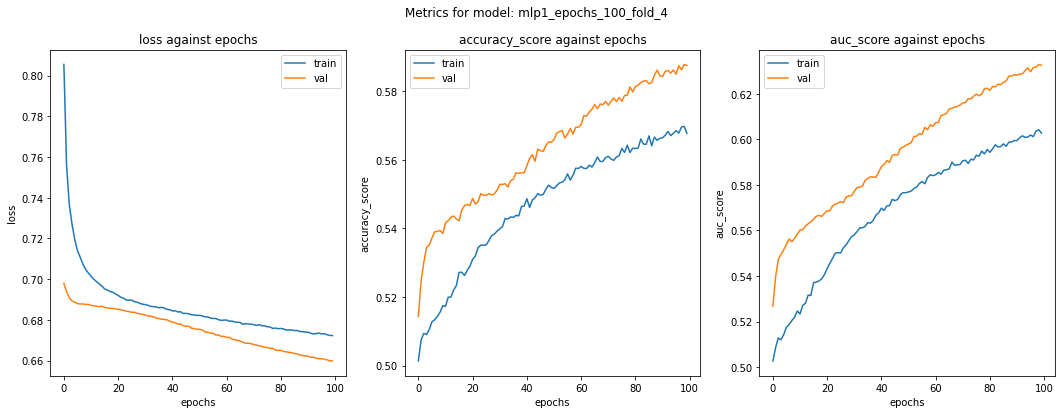

training model fold 5
Epoch 1/100
246/246 [==============================] - 4s 9ms/step - loss: 0.8232 - accuracy: 0.5052 - auc: 0.5070 - val_loss: 0.7018 - val_accuracy: 0.5126 - val_auc: 0.5265
Epoch 2/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7581 - accuracy: 0.5069 - auc: 0.5087 - val_loss: 0.6966 - val_accuracy: 0.5239 - val_auc: 0.5372
Epoch 3/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7372 - accuracy: 0.5091 - auc: 0.5132 - val_loss: 0.6932 - val_accuracy: 0.5267 - val_auc: 0.5425
Epoch 4/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7275 - accuracy: 0.5091 - auc: 0.5136 - val_loss: 0.6913 - val_accuracy: 0.5288 - val_auc: 0.5450
Epoch 5/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7204 - accuracy: 0.5111 - auc: 0.5151 - val_loss: 0.6898 - val_accuracy: 0.5339 - val_auc: 0.5484
Epoch 6/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7158 - accuracy: 0.5119 - 

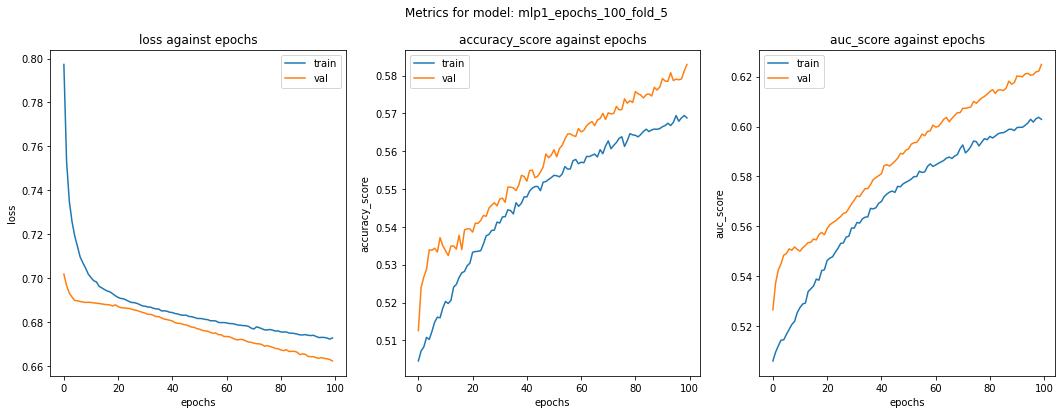

training model fold 6
Epoch 1/100
246/246 [==============================] - 4s 9ms/step - loss: 0.8221 - accuracy: 0.5029 - auc: 0.5044 - val_loss: 0.6974 - val_accuracy: 0.5147 - val_auc: 0.5192
Epoch 2/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7557 - accuracy: 0.5086 - auc: 0.5116 - val_loss: 0.6948 - val_accuracy: 0.5226 - val_auc: 0.5321
Epoch 3/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7390 - accuracy: 0.5080 - auc: 0.5110 - val_loss: 0.6928 - val_accuracy: 0.5224 - val_auc: 0.5357
Epoch 4/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7268 - accuracy: 0.5099 - auc: 0.5129 - val_loss: 0.6909 - val_accuracy: 0.5299 - val_auc: 0.5433
Epoch 5/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7192 - accuracy: 0.5125 - auc: 0.5173 - val_loss: 0.6895 - val_accuracy: 0.5323 - val_auc: 0.5446
Epoch 6/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7157 - accuracy: 0.5108 - 

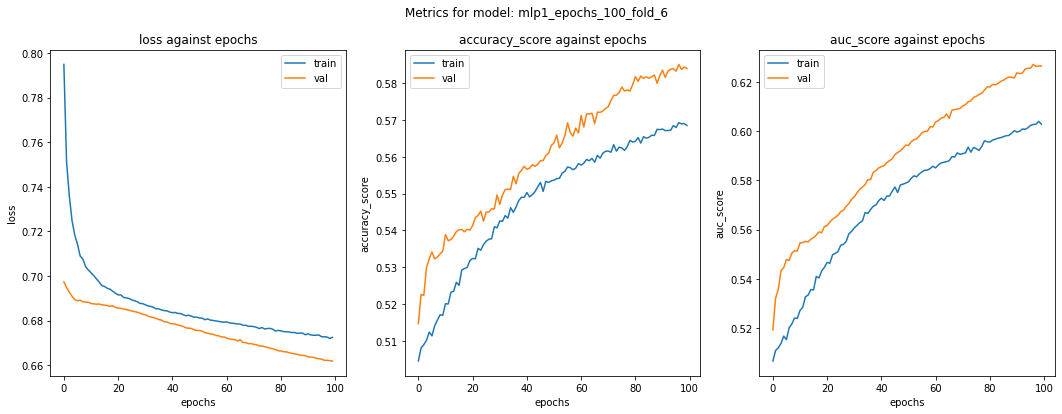

training model fold 7
Epoch 1/100
246/246 [==============================] - 4s 9ms/step - loss: 0.8383 - accuracy: 0.5020 - auc: 0.5016 - val_loss: 0.7004 - val_accuracy: 0.5117 - val_auc: 0.5238
Epoch 2/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7619 - accuracy: 0.5062 - auc: 0.5093 - val_loss: 0.6964 - val_accuracy: 0.5181 - val_auc: 0.5300
Epoch 3/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7409 - accuracy: 0.5090 - auc: 0.5125 - val_loss: 0.6931 - val_accuracy: 0.5241 - val_auc: 0.5327
Epoch 4/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7303 - accuracy: 0.5108 - auc: 0.5126 - val_loss: 0.6915 - val_accuracy: 0.5244 - val_auc: 0.5379
Epoch 5/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7225 - accuracy: 0.5101 - auc: 0.5144 - val_loss: 0.6902 - val_accuracy: 0.5292 - val_auc: 0.5402
Epoch 6/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7168 - accuracy: 0.5128 - 

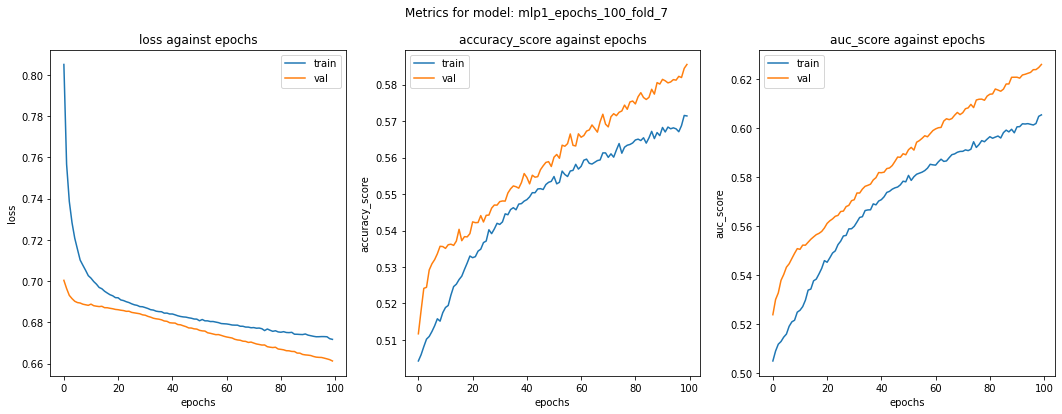

training model fold 8
Epoch 1/100
246/246 [==============================] - 4s 9ms/step - loss: 0.8518 - accuracy: 0.4989 - auc: 0.4991 - val_loss: 0.6994 - val_accuracy: 0.5164 - val_auc: 0.5256
Epoch 2/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7636 - accuracy: 0.5089 - auc: 0.5106 - val_loss: 0.6953 - val_accuracy: 0.5215 - val_auc: 0.5339
Epoch 3/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7439 - accuracy: 0.5091 - auc: 0.5112 - val_loss: 0.6911 - val_accuracy: 0.5263 - val_auc: 0.5424
Epoch 4/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7300 - accuracy: 0.5099 - auc: 0.5138 - val_loss: 0.6900 - val_accuracy: 0.5291 - val_auc: 0.5476
Epoch 5/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7218 - accuracy: 0.5137 - auc: 0.5182 - val_loss: 0.6889 - val_accuracy: 0.5343 - val_auc: 0.5502
Epoch 6/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7167 - accuracy: 0.5137 - 

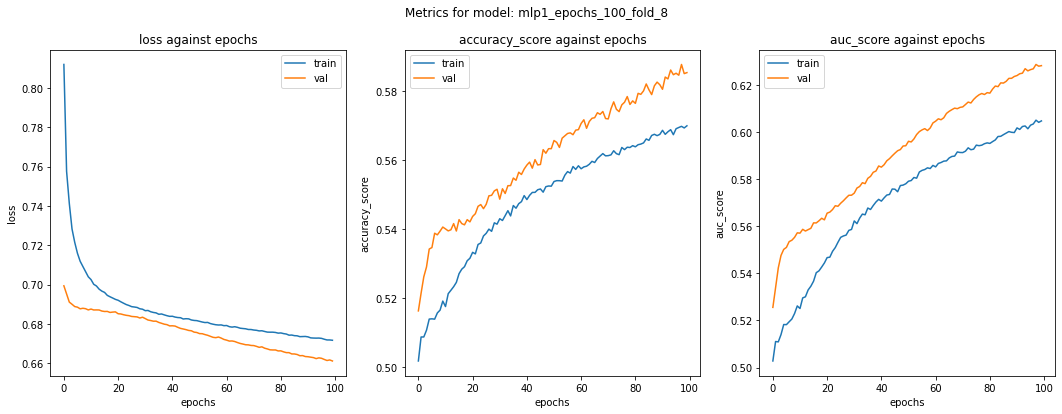

training model fold 9
Epoch 1/100
246/246 [==============================] - 4s 10ms/step - loss: 0.8336 - accuracy: 0.5020 - auc: 0.5034 - val_loss: 0.6972 - val_accuracy: 0.5188 - val_auc: 0.5254
Epoch 2/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7607 - accuracy: 0.5052 - auc: 0.5070 - val_loss: 0.6952 - val_accuracy: 0.5251 - val_auc: 0.5336
Epoch 3/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7416 - accuracy: 0.5068 - auc: 0.5103 - val_loss: 0.6939 - val_accuracy: 0.5263 - val_auc: 0.5360
Epoch 4/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7282 - accuracy: 0.5096 - auc: 0.5137 - val_loss: 0.6921 - val_accuracy: 0.5269 - val_auc: 0.5389
Epoch 5/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7204 - accuracy: 0.5130 - auc: 0.5160 - val_loss: 0.6907 - val_accuracy: 0.5298 - val_auc: 0.5427
Epoch 6/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7156 - accuracy: 0.5128 -

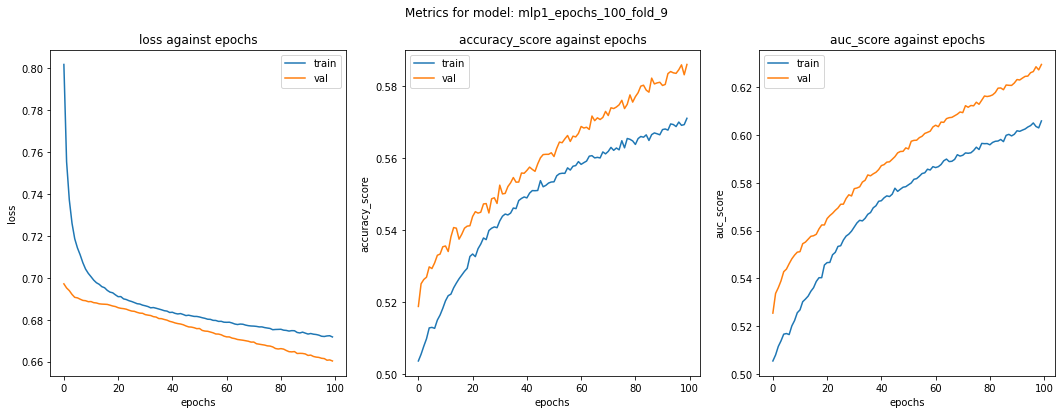

training model fold 10
Epoch 1/100
246/246 [==============================] - 4s 10ms/step - loss: 0.8172 - accuracy: 0.5015 - auc: 0.5020 - val_loss: 0.6948 - val_accuracy: 0.5188 - val_auc: 0.5267
Epoch 2/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7498 - accuracy: 0.5076 - auc: 0.5111 - val_loss: 0.6931 - val_accuracy: 0.5258 - val_auc: 0.5358
Epoch 3/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7341 - accuracy: 0.5106 - auc: 0.5117 - val_loss: 0.6912 - val_accuracy: 0.5294 - val_auc: 0.5394
Epoch 4/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7231 - accuracy: 0.5117 - auc: 0.5135 - val_loss: 0.6905 - val_accuracy: 0.5288 - val_auc: 0.5410
Epoch 5/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7173 - accuracy: 0.5102 - auc: 0.5145 - val_loss: 0.6903 - val_accuracy: 0.5279 - val_auc: 0.5427
Epoch 6/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7110 - accuracy: 0.5146 

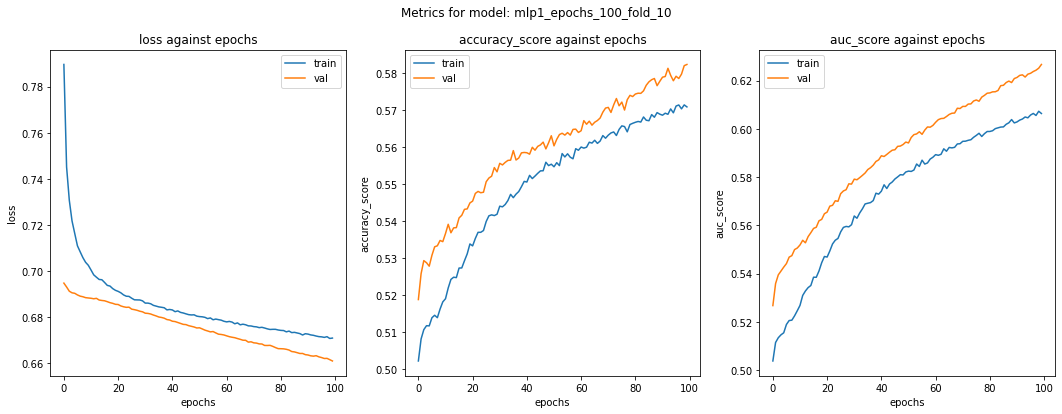

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [931.4700811009488, 0.5847077388287976, 0.5841002859025781, 8778.8, 7553.9, 6126.3, 5474.1]
saved model metrics

model_name:  mlp1_epochs_400
model_params:  batch_size=1024, hidden_unit=[100, 200, 400, 200], activation=<function relu at 0x7f9e9fea93b0>, dropout_rate=[0.2, 0.2, 0.2, 0.2, 0.2], learning_rate=0.0001, epoch=400
training model fold 1
Epoch 1/400
246/246 [==============================] - 4s 10ms/step - loss: 0.8189 - accuracy: 0.5037 - auc: 0.5049 - val_loss: 0.6954 - val_accuracy: 0.5146 - val_auc: 0.5222
Epoch 2/400
246/246 [==============================] - 2s 8ms/step - loss: 0.7516 - accuracy: 0.5060 - auc: 0.5085 - val_loss: 0.6931 - val_accuracy: 0.5221 - val_auc: 0.5337
Epoch 3/400
246/246 [==============================] - 2s 8ms/step - loss: 0.7341 - accuracy: 0.5072 - auc: 0.5094 - val_loss: 0.6910 - val_accuracy: 0.5258 - val_auc: 0.5413
Epoch 4/400
246/246 

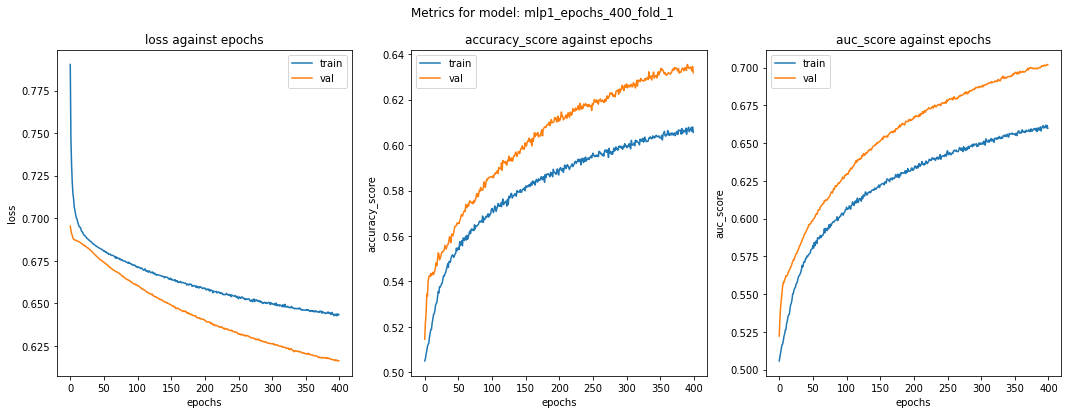

training model fold 2
Epoch 1/400
246/246 [==============================] - 4s 10ms/step - loss: 0.8209 - accuracy: 0.5038 - auc: 0.5044 - val_loss: 0.6978 - val_accuracy: 0.5165 - val_auc: 0.5208
Epoch 2/400
246/246 [==============================] - 2s 8ms/step - loss: 0.7558 - accuracy: 0.5059 - auc: 0.5082 - val_loss: 0.6964 - val_accuracy: 0.5254 - val_auc: 0.5316
Epoch 3/400
246/246 [==============================] - 2s 8ms/step - loss: 0.7385 - accuracy: 0.5080 - auc: 0.5101 - val_loss: 0.6936 - val_accuracy: 0.5303 - val_auc: 0.5394
Epoch 4/400
246/246 [==============================] - 2s 8ms/step - loss: 0.7268 - accuracy: 0.5109 - auc: 0.5138 - val_loss: 0.6908 - val_accuracy: 0.5297 - val_auc: 0.5454
Epoch 5/400
246/246 [==============================] - 2s 8ms/step - loss: 0.7187 - accuracy: 0.5107 - auc: 0.5146 - val_loss: 0.6898 - val_accuracy: 0.5286 - val_auc: 0.5476
Epoch 6/400
246/246 [==============================] - 2s 8ms/step - loss: 0.7143 - accuracy: 0.5127 -

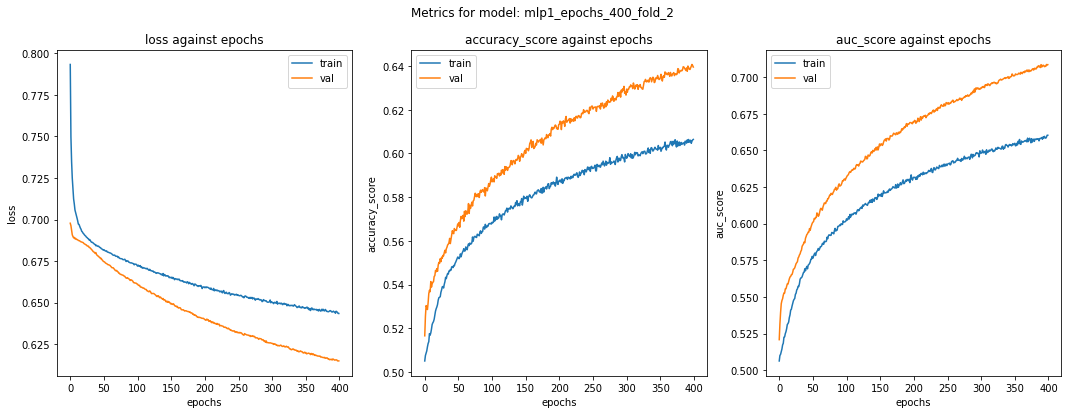

training model fold 3
Epoch 1/400
246/246 [==============================] - 4s 10ms/step - loss: 0.8334 - accuracy: 0.5029 - auc: 0.5057 - val_loss: 0.6961 - val_accuracy: 0.5187 - val_auc: 0.5272
Epoch 2/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7642 - accuracy: 0.5075 - auc: 0.5104 - val_loss: 0.6956 - val_accuracy: 0.5249 - val_auc: 0.5341
Epoch 3/400
246/246 [==============================] - 2s 8ms/step - loss: 0.7429 - accuracy: 0.5081 - auc: 0.5115 - val_loss: 0.6925 - val_accuracy: 0.5241 - val_auc: 0.5393
Epoch 4/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7321 - accuracy: 0.5069 - auc: 0.5109 - val_loss: 0.6904 - val_accuracy: 0.5298 - val_auc: 0.5435
Epoch 5/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7236 - accuracy: 0.5098 - auc: 0.5140 - val_loss: 0.6897 - val_accuracy: 0.5297 - val_auc: 0.5470
Epoch 6/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7165 - accuracy: 0.5131 -

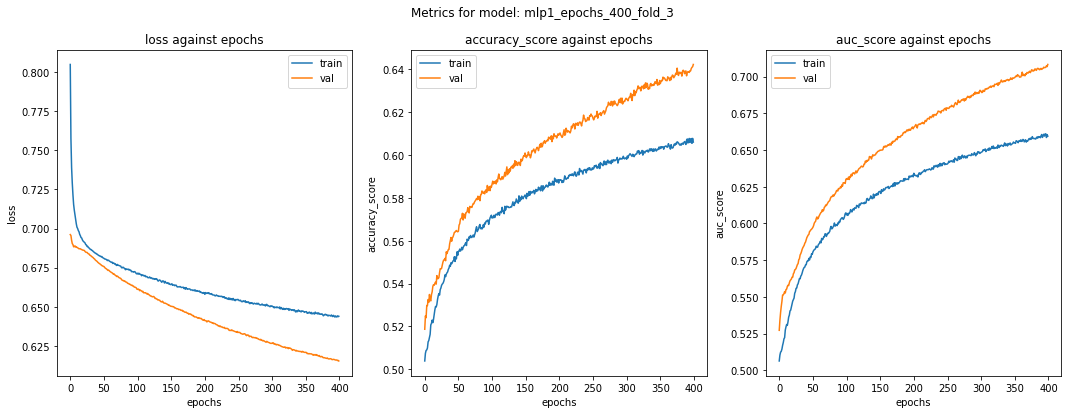

training model fold 4
Epoch 1/400
246/246 [==============================] - 4s 10ms/step - loss: 0.8227 - accuracy: 0.5038 - auc: 0.5053 - val_loss: 0.6953 - val_accuracy: 0.5168 - val_auc: 0.5274
Epoch 2/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7583 - accuracy: 0.5047 - auc: 0.5073 - val_loss: 0.6930 - val_accuracy: 0.5244 - val_auc: 0.5386
Epoch 3/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7377 - accuracy: 0.5078 - auc: 0.5123 - val_loss: 0.6907 - val_accuracy: 0.5280 - val_auc: 0.5442
Epoch 4/400
246/246 [==============================] - 2s 8ms/step - loss: 0.7256 - accuracy: 0.5083 - auc: 0.5134 - val_loss: 0.6894 - val_accuracy: 0.5312 - val_auc: 0.5480
Epoch 5/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7199 - accuracy: 0.5102 - auc: 0.5154 - val_loss: 0.6890 - val_accuracy: 0.5351 - val_auc: 0.5505
Epoch 6/400
246/246 [==============================] - 2s 8ms/step - loss: 0.7147 - accuracy: 0.5110 -

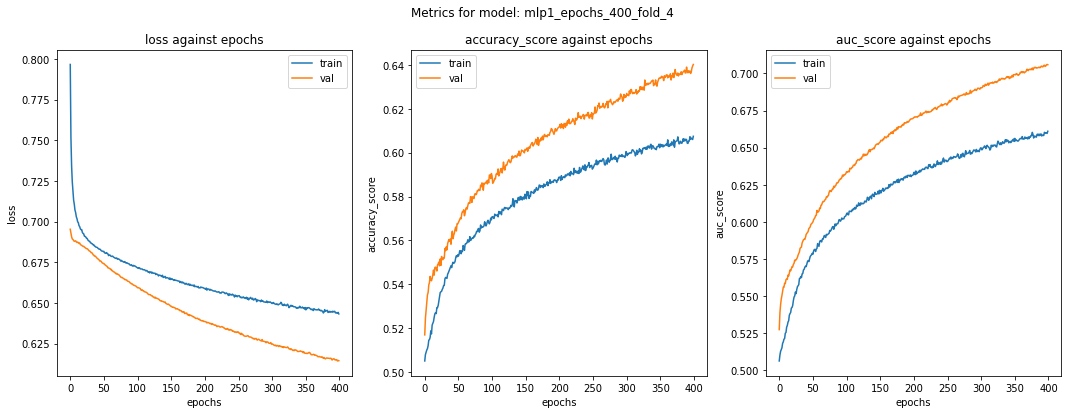

training model fold 5
Epoch 1/400
246/246 [==============================] - 4s 11ms/step - loss: 0.8302 - accuracy: 0.5041 - auc: 0.5059 - val_loss: 0.7020 - val_accuracy: 0.5131 - val_auc: 0.5246
Epoch 2/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7591 - accuracy: 0.5074 - auc: 0.5105 - val_loss: 0.6963 - val_accuracy: 0.5215 - val_auc: 0.5300
Epoch 3/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7424 - accuracy: 0.5070 - auc: 0.5088 - val_loss: 0.6934 - val_accuracy: 0.5260 - val_auc: 0.5396
Epoch 4/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7290 - accuracy: 0.5105 - auc: 0.5140 - val_loss: 0.6908 - val_accuracy: 0.5293 - val_auc: 0.5427
Epoch 5/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7222 - accuracy: 0.5111 - auc: 0.5157 - val_loss: 0.6903 - val_accuracy: 0.5308 - val_auc: 0.5447
Epoch 6/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7154 - accuracy: 0.5143 -

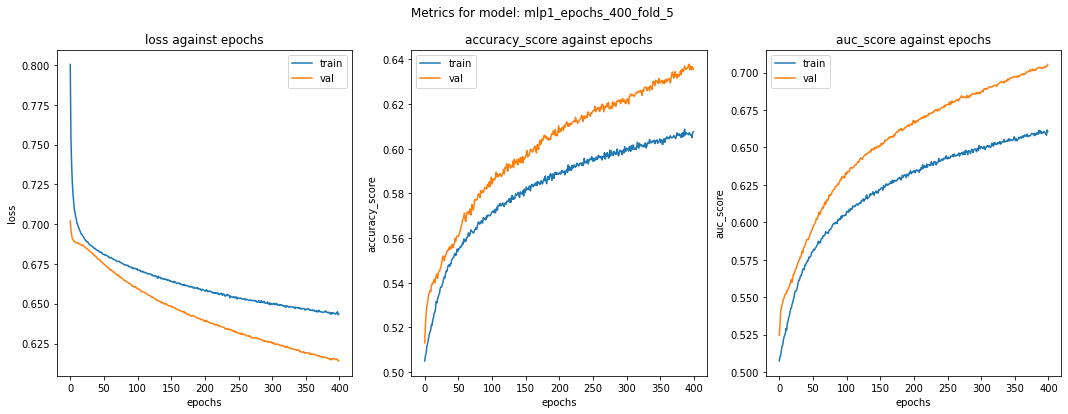

training model fold 6
Epoch 1/400
246/246 [==============================] - 4s 11ms/step - loss: 0.8216 - accuracy: 0.5047 - auc: 0.5054 - val_loss: 0.6986 - val_accuracy: 0.5106 - val_auc: 0.5259
Epoch 2/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7557 - accuracy: 0.5056 - auc: 0.5072 - val_loss: 0.6937 - val_accuracy: 0.5235 - val_auc: 0.5356
Epoch 3/400
246/246 [==============================] - 3s 10ms/step - loss: 0.7372 - accuracy: 0.5096 - auc: 0.5129 - val_loss: 0.6928 - val_accuracy: 0.5245 - val_auc: 0.5396
Epoch 4/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7239 - accuracy: 0.5107 - auc: 0.5167 - val_loss: 0.6906 - val_accuracy: 0.5294 - val_auc: 0.5425
Epoch 5/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7189 - accuracy: 0.5132 - auc: 0.5169 - val_loss: 0.6913 - val_accuracy: 0.5301 - val_auc: 0.5433
Epoch 6/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7152 - accuracy: 0.5

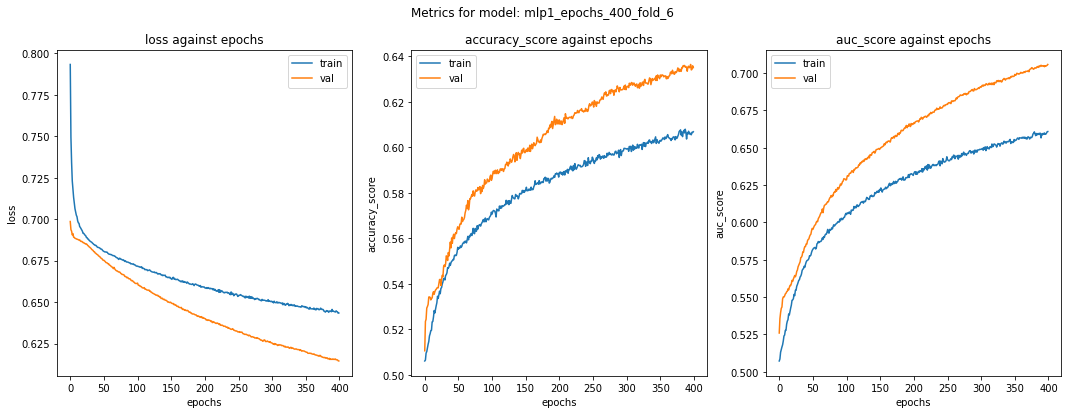

training model fold 7
Epoch 1/400
246/246 [==============================] - 5s 12ms/step - loss: 0.8268 - accuracy: 0.5021 - auc: 0.5013 - val_loss: 0.7018 - val_accuracy: 0.5155 - val_auc: 0.5220
Epoch 2/400
246/246 [==============================] - 3s 10ms/step - loss: 0.7601 - accuracy: 0.5046 - auc: 0.5052 - val_loss: 0.6973 - val_accuracy: 0.5233 - val_auc: 0.5293
Epoch 3/400
246/246 [==============================] - 3s 10ms/step - loss: 0.7367 - accuracy: 0.5090 - auc: 0.5122 - val_loss: 0.6924 - val_accuracy: 0.5289 - val_auc: 0.5378
Epoch 4/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7269 - accuracy: 0.5102 - auc: 0.5127 - val_loss: 0.6906 - val_accuracy: 0.5315 - val_auc: 0.5419
Epoch 5/400
246/246 [==============================] - 3s 10ms/step - loss: 0.7186 - accuracy: 0.5124 - auc: 0.5163 - val_loss: 0.6892 - val_accuracy: 0.5333 - val_auc: 0.5472
Epoch 6/400
246/246 [==============================] - 3s 10ms/step - loss: 0.7139 - accuracy: 0.5

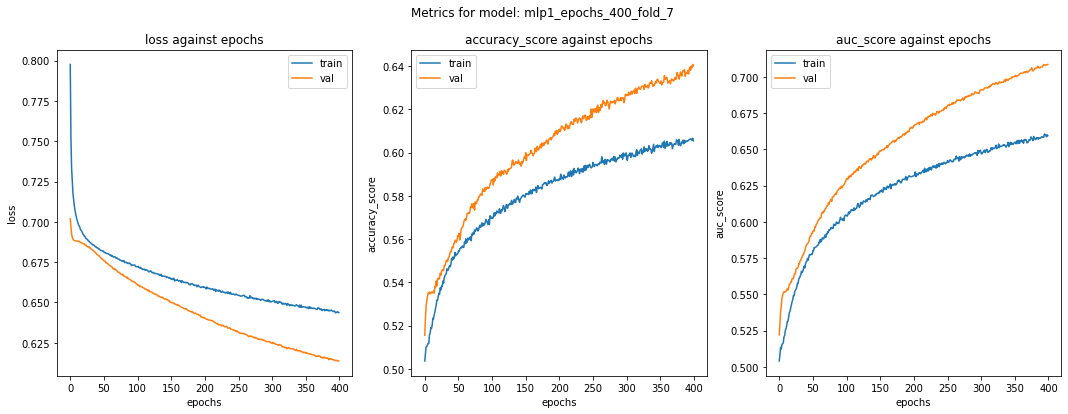

training model fold 8
Epoch 1/400
246/246 [==============================] - 4s 11ms/step - loss: 0.8379 - accuracy: 0.5007 - auc: 0.5017 - val_loss: 0.6982 - val_accuracy: 0.5148 - val_auc: 0.5243
Epoch 2/400
246/246 [==============================] - 3s 10ms/step - loss: 0.7627 - accuracy: 0.5076 - auc: 0.5110 - val_loss: 0.6952 - val_accuracy: 0.5200 - val_auc: 0.5309
Epoch 3/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7426 - accuracy: 0.5104 - auc: 0.5125 - val_loss: 0.6919 - val_accuracy: 0.5255 - val_auc: 0.5382
Epoch 4/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7306 - accuracy: 0.5089 - auc: 0.5126 - val_loss: 0.6900 - val_accuracy: 0.5312 - val_auc: 0.5455
Epoch 5/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7224 - accuracy: 0.5122 - auc: 0.5151 - val_loss: 0.6887 - val_accuracy: 0.5328 - val_auc: 0.5489
Epoch 6/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7157 - accuracy: 0.5

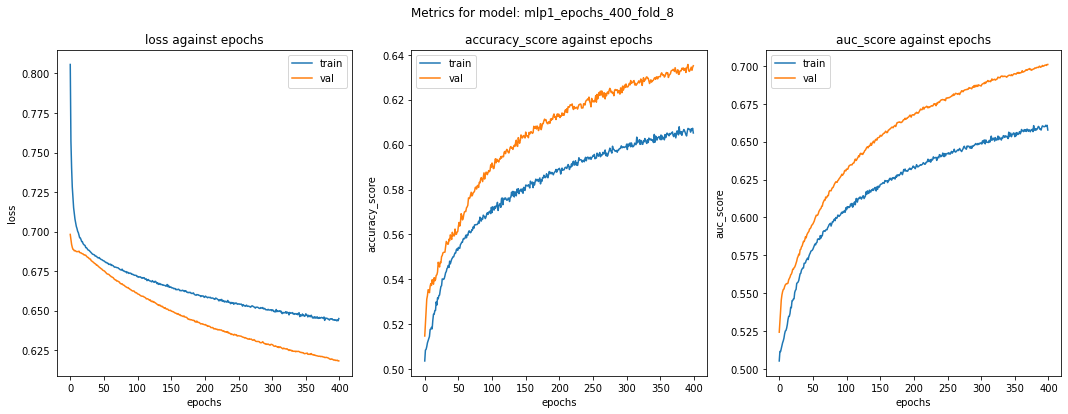

training model fold 9
Epoch 1/400
246/246 [==============================] - 5s 12ms/step - loss: 0.8384 - accuracy: 0.5015 - auc: 0.5021 - val_loss: 0.6978 - val_accuracy: 0.5123 - val_auc: 0.5209
Epoch 2/400
246/246 [==============================] - 3s 10ms/step - loss: 0.7657 - accuracy: 0.5038 - auc: 0.5060 - val_loss: 0.6957 - val_accuracy: 0.5194 - val_auc: 0.5315
Epoch 3/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7431 - accuracy: 0.5061 - auc: 0.5094 - val_loss: 0.6926 - val_accuracy: 0.5256 - val_auc: 0.5390
Epoch 4/400
246/246 [==============================] - 3s 11ms/step - loss: 0.7317 - accuracy: 0.5083 - auc: 0.5110 - val_loss: 0.6907 - val_accuracy: 0.5277 - val_auc: 0.5426
Epoch 5/400
246/246 [==============================] - 3s 10ms/step - loss: 0.7216 - accuracy: 0.5109 - auc: 0.5142 - val_loss: 0.6895 - val_accuracy: 0.5325 - val_auc: 0.5481
Epoch 6/400
246/246 [==============================] - 3s 11ms/step - loss: 0.7156 - accuracy: 0.5

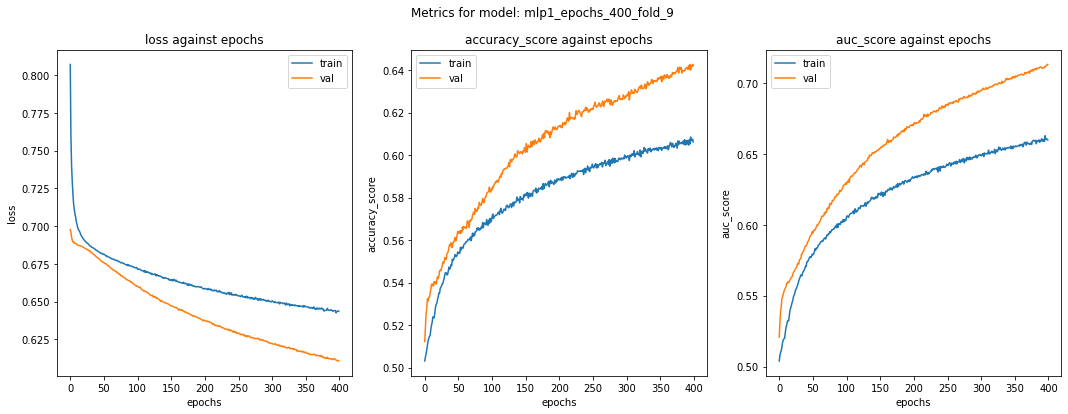

training model fold 10
Epoch 1/400
246/246 [==============================] - 4s 12ms/step - loss: 0.8294 - accuracy: 0.5055 - auc: 0.5072 - val_loss: 0.6979 - val_accuracy: 0.5247 - val_auc: 0.5294
Epoch 2/400
246/246 [==============================] - 3s 11ms/step - loss: 0.7610 - accuracy: 0.5062 - auc: 0.5079 - val_loss: 0.6944 - val_accuracy: 0.5299 - val_auc: 0.5377
Epoch 3/400
246/246 [==============================] - 3s 11ms/step - loss: 0.7429 - accuracy: 0.5075 - auc: 0.5077 - val_loss: 0.6915 - val_accuracy: 0.5334 - val_auc: 0.5443
Epoch 4/400
246/246 [==============================] - 3s 10ms/step - loss: 0.7287 - accuracy: 0.5092 - auc: 0.5119 - val_loss: 0.6904 - val_accuracy: 0.5351 - val_auc: 0.5474
Epoch 5/400
246/246 [==============================] - 3s 11ms/step - loss: 0.7215 - accuracy: 0.5096 - auc: 0.5140 - val_loss: 0.6890 - val_accuracy: 0.5356 - val_auc: 0.5504
Epoch 6/400
246/246 [==============================] - 3s 11ms/step - loss: 0.7153 - accuracy: 0.

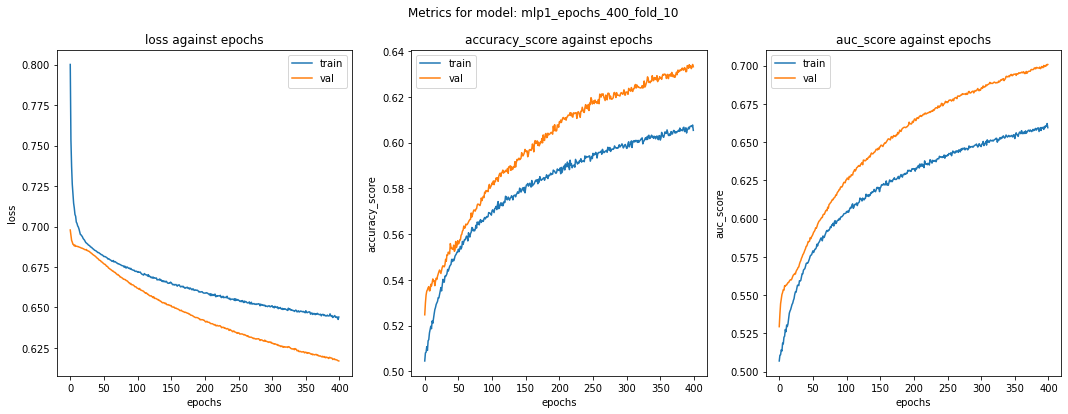

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [1557.7783854931924, 0.6375053454820632, 0.6372330063296902, 9291.3, 8516.2, 5164.0, 4961.6]
saved model metrics


In [16]:
for batch_size in batch_sizes:
  for hidden_unit in hidden_units:
    for activation in activations:
      for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
          for epoch in epochs:

            output_filename = "CV_SCORES_AVE_NNDL.csv"
            workbook_name = "11A_nndl_cv_mlp1_epochs"
            model_name = f"mlp1_epochs_{epoch}"
            model_params = f"batch_size={batch_size}, hidden_unit={hidden_unit}, activation={activation}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, epoch={epoch}"
                    
            print("")
            print("model_name: ", model_name)
            print("model_params: ", model_params)

            # cross validation
            cv_scores = []

            for i, (train_idx, val_idx) in enumerate(kf.split(x_train)):
              # train-val data (for utility score calculation) 
              train_cv, val_cv = train.iloc[train_idx], train.iloc[val_idx]
              # train-val features 
              x_train_cv, x_val_cv, y_train_cv, y_val_cv = x_train[train_idx], x_train[val_idx], y_train[train_idx], y_train[val_idx]

              # scaling data to make it easier for models to train
              scaler = StandardScaler().fit(x_train_cv)
              x_train_cv = scaler.transform(x_train_cv)

              # test set scaled on the same scaler as train, because models are fitted on the train distributions and not test distributions
              x_val_cv = scaler.transform(x_val_cv)

              print(f"training model fold {i+1}")

              model = create_mlp(x_train_cv.shape[1], hidden_unit, activation, dropout_rate, learning_rate)
              model_name_fold = model_name + f"_fold_{i+1}"
              # CheckpointCallback = ModelCheckpoint(str(PATH_CHECKPOINTS / (model_name + '.hdf5')), monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='auto', save_freq='epoch')

              history = model.fit(
                  x_train_cv, 
                  y_train_cv, 
                  epochs=epoch, 
                  batch_size=batch_size,
                  validation_data=(x_val_cv, y_val_cv),
                  # callbacks = [CheckpointCallback]
              )

              model_score = model_scores(model, test=val_cv, x_test=x_val_cv, y_test=y_val_cv)
              cv_scores.append(model_score)

              history_saver(history, model_name_fold, PATH_HISTORIES, already_npy=False)
              history = history_loader(model_name_fold, PATH_HISTORIES)
              plot_metrics(history, model_name_fold, PATH_FIGURES)

            # mean of cv scores
            cv_scores_ave = [sum(ele) / len(cv_scores) for ele in zip(*cv_scores)]
            print("cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg")
            print("cv_scores_ave: ", cv_scores_ave)

            # save average scores
            save_scores(output_filename, workbook_name, model_name, model_params, *cv_scores_ave)


In [17]:
# '''
# predict on the test set. load best weights from checkpoints
# '''
# # model.load_weights(str(PATH_CHECKPOINTS / (model_name + '.hdf5')))

# test_metrics = model.evaluate(x_test, steps=3)

# test_metrics_dict = {
#     'test_loss': test_metrics[0]
# }

# np.save(PATH_PREDICTIONS/str(model_name + "_prediction_score"), test_metrics_dict)

In [18]:
# y_pred = (model.predict(x_test) > 0.5).astype(int)
# utility_score(test, y_pred)

# Conclusion